In [2]:
from branca.element import Figure
from datetime import datetime, date
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from shapely.geometry import Point
from sklearn.metrics import (
    f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,
    roc_auc_score
)
from tqdm.notebook import tqdm
from typing import List, Tuple
from rasterio.plot import reshape_as_image

import folium
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.patches as patches
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import xarray as xr

sys.path.append("..")
from src.utils import get_dvc_dir
from src.utils import tifs_dir, raw_dir
from src.ETL.constants import LAT, LON

from notebook_utils import get_validation_df

load_dotenv();

# 1. Loading model and data

In [3]:
df = get_validation_df("Ethiopia_Tigray_2020")
df["start_date"] = pd.to_datetime(df["start_date"])
len(df[df["errors"]])

Loading data into memory


Caching files: 100%|██████████| 499/499 [00:00<00:00, 1507.07it/s]


111

In [4]:
def metrics_from_df(df):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    metric_functions = [f1_score, accuracy_score, precision_score, recall_score, roc_auc_score]
    metrics = {m.__name__: round(m(y_true, y_pred), 4) for m in metric_functions}
    return metrics

# 2. Plotting all predictions on map

In [5]:
map_box_token = os.environ.get("MAPBOX_TOKEN")
mapbox_kwargs = {
    "tiles": 'https://api.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token='+map_box_token,
    "attr": 'mapbox.com',
    "name": "Mapbox"
}

def plot_map(
    color_bboxes: List[Tuple[str, List[Tuple[float, float]]]] = None, 
    color_markers: List[Tuple[str, List[Tuple[float, float]]]] = None, 
    zoom_start: int = 15, 
    width: int = 500, 
    height: int = 200,
    map_kwargs=mapbox_kwargs
) -> Figure:
    if color_bboxes:
        # First bbox is used as center
        first_points = color_bboxes[0][1]
        
    elif color_markers:
        # First point is used as center
        first_points = color_markers[0][1]
        
    else:
        raise ValueError("At least one of color_bboxes or color_markers must be set")
        
    center = list(np.array([p[i] for p in first_points]).mean() for i in [0,1])

    m = folium.Map(location=center, zoom_start=zoom_start, **map_kwargs)
    
    if color_bboxes:
        for color, bbox in color_bboxes:
            folium.Rectangle(bounds=bbox, color=color).add_to(m)
        
    if color_markers:
        feature_group = folium.FeatureGroup('markers')
        for color, markers in color_markers:
            for marker in markers:
                folium.Marker(location=marker, icon=folium.Icon(color=color)).add_to(feature_group)
        feature_group.add_to(m)

    fig = Figure(width=width, height=height)
    return fig.add_child(m)

def bbox_from_corners(x_min: float, x_max: float, y_min: float, y_max: float) -> List[Tuple[float, float]]:
    points = [(y_min, x_min), (y_min, x_max), (y_max, x_min), (y_max, x_max)]
    return points

def label_to_bbox(label_lon, label_lat, bbox_size=0.00005):
    max_lon = label_lon + bbox_size
    max_lat = label_lat + bbox_size
    min_lon = label_lon - bbox_size
    min_lat = label_lat - bbox_size
    bbox = bbox_from_corners(min_lon, max_lon, min_lat, max_lat)
    return bbox

def instance_to_bbox(inst):
    max_lon = inst.instance_lon + bbox_size
    max_lat = inst.instance_lat + bbox_size
    min_lon = inst.instance_lon - bbox_size
    min_lat = inst.instance_lat - bbox_size
    bbox = bbox_from_corners(min_lon, max_lon, min_lat, max_lat)
    return bbox

In [6]:
df["color"] = df["errors"].apply(lambda err: "red" if err else "yellow")
df["bboxes"] = df.apply(lambda row: label_to_bbox(row[LON], row[LAT]), axis=1)
df["tif_bboxes"] = df.apply(lambda row: label_to_bbox(row["instance_lon"], row["instance_lat"]), axis=1)

In [7]:
color_bboxes = [("black", bbox) for bbox in df["tif_bboxes"]] + [(color, bbox) for color, bbox in zip(df["color"], df["bboxes"])]

In [8]:
plot_map(color_bboxes=color_bboxes, width=800, height=600, zoom_start=7, map_kwargs=mapbox_kwargs)

**Conclusion** No consistent pattern from distribution of errors. We get all the water ones right at least.

In [9]:
west_df = df[df[LON] > df[LON].median()].copy()
east_df = df[df[LON] <= df[LON].median()].copy()
def legend_str(prefix, df): 
    crop_percent = round(df["y_true"].value_counts(normalize=True)[1], 4)
    return f"{prefix} (Size: {len(df) }, Crop {crop_percent})"

all_dfs = {
    legend_str("All", df): df, 
    legend_str("East", east_df): east_df, 
    legend_str("West", west_df): west_df
}
metrics = {k: metrics_from_df(d) for k, d in all_dfs.items()}

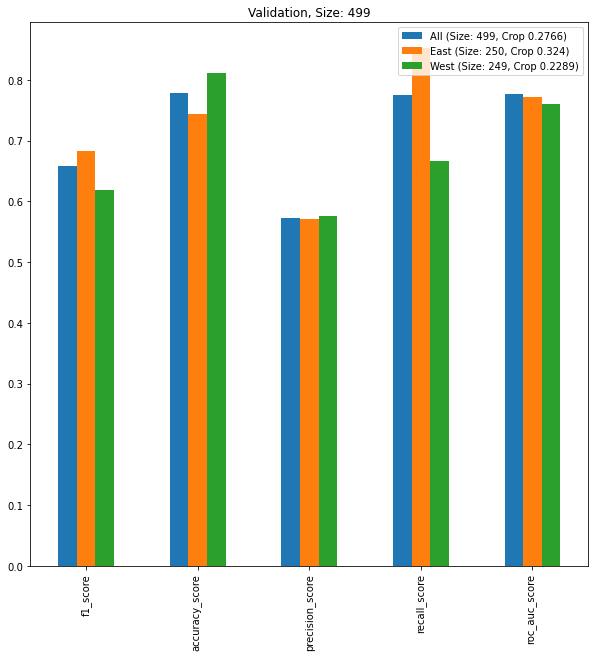

In [10]:
pd.DataFrame(metrics).plot(kind="bar", figsize=(10,10), title=f"Validation, Size: {len(df)}");

# 4. Analyzing individal predictions

In [11]:
def plot_tif(tif_name, start_date, inst_lon, inst_lat, crop_prob, max_val=2000):
    #tif = load_tif(tifs_dir / tif_name, start_date, 30)
    fig, axes = plt.subplots(4, 6, figsize=(30,20), sharey="row")

    # Create a Rectangle patch
    #x = int(np.where(tif.x==inst_lon)[0])
   # y = int(np.where(tif.y==inst_lat)[0])
    #band_values = tif.sel(x=inst_lon).sel(y=inst_lat).values
    
    images = []
    if crop_prob > 0.5:
        color = "green"
    else:
        color = "red"
    for i in range(12):
        col = i%6
        row = (i//6)*2
        
        # Plot images
        #images.append(get_colors(tif.values[i], max_val))
        ax = axes[row+1][col]
        ax.imshow(images[i])
        # Add the patch to the Axes
        rect = patches.Rectangle(xy=(x, y), width=1, height=1, linewidth=1, edgecolor="yellow", facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f"Month {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
        
        # Plot bar charts 
        ax = axes[row][col]
        bars = ax.bar(list(range(band_values.shape[1])), band_values[i], color="lightgray")
        bars[1].set_color("blue")
        bars[2].set_color("green")
        bars[3].set_color("red")
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        
    fig.tight_layout()
    return np.array(images)

def get_colors(tif_values, max_val=2000):
    colors = (tif_values[np.array([3,2,1])] * 10000).astype(np.float64)

    min_val = 0

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[0]):
        colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

    # rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
    # and so our array needs to be reshaped
    colors_reshaped = reshape_as_image(colors)
    return colors_reshaped

def gmap_url(lon, lat):
    return f"http://maps.google.com/maps?z=12&t=m&q=loc:{lat}+{lon}"


In [12]:
i = -1

In [13]:
raw_df = pd.read_csv(raw_dir / df["dataset"].iloc[0] / df[df["errors"]]["source"].iloc[0].split(",")[0])

0


IndexError: list index out of range

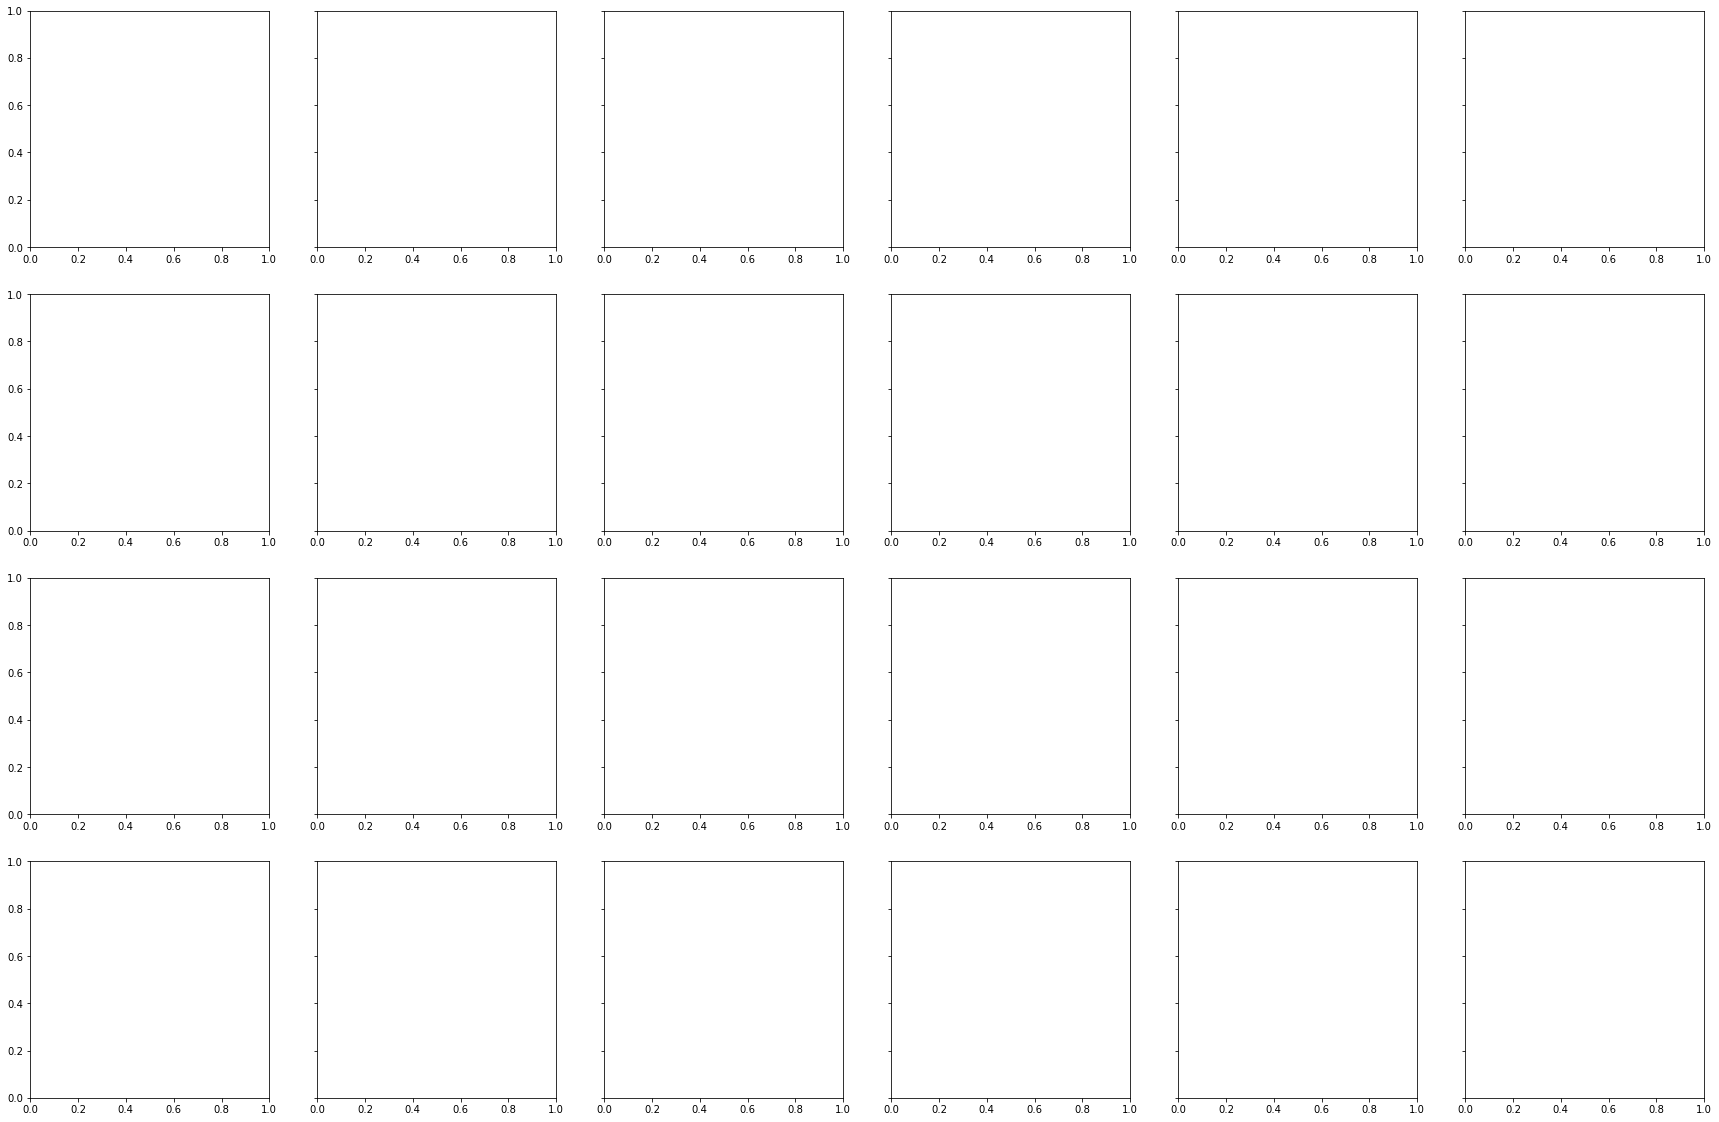

In [14]:
i += 1
error = df[df["errors"]].iloc[i]
print(i)
images = plot_tif(
    error.source_file,
    error.start_date,
    error.instance_lon, 
    error.instance_lat, 
    error.crop_probability, 
    max_val=2000)

# Prints google maps url
url = gmap_url(error[LON], error[LAT])
print(url)
print(f"Crop probability: {error.crop_probability}")
print(f"Crop prediction: {error.y_pred_decimal}")

# Plots square on mapbox
#plot_map(color_bboxes=bboxes[i], width=600, height=400, zoom_start=18, map_kwargs=mapbox_kwargs)

# Red = non-crop, but crop was predicted
# Green = crop, but non-crop was predicted
# White = tif location

raw_df[(np.isclose(raw_df["lon"], error[LON])) & (np.isclose(raw_df["lat"], error[LAT]))]

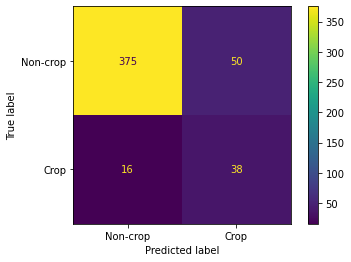

In [39]:
cm = confusion_matrix(df["y_true"], df["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-crop", "Crop"])
disp.plot()

# 5. Individual error categories

In [169]:
non_crops_model_got_wrong = {
    "lot's of vegetation": 21,
    "shrubs in a field": 35,
    "field": 5,
    "it should be crop": 3,
    "swamp": 1,
    "dirt": 3,
    "on field boundary": 2,
    "hard to tell": 3
}

crops_model_got_wrong = {
    "fallow field?": 5,
    "on field boundary": 9,
    "clearly it's crop": 9,
    "hard to tell": 2
}

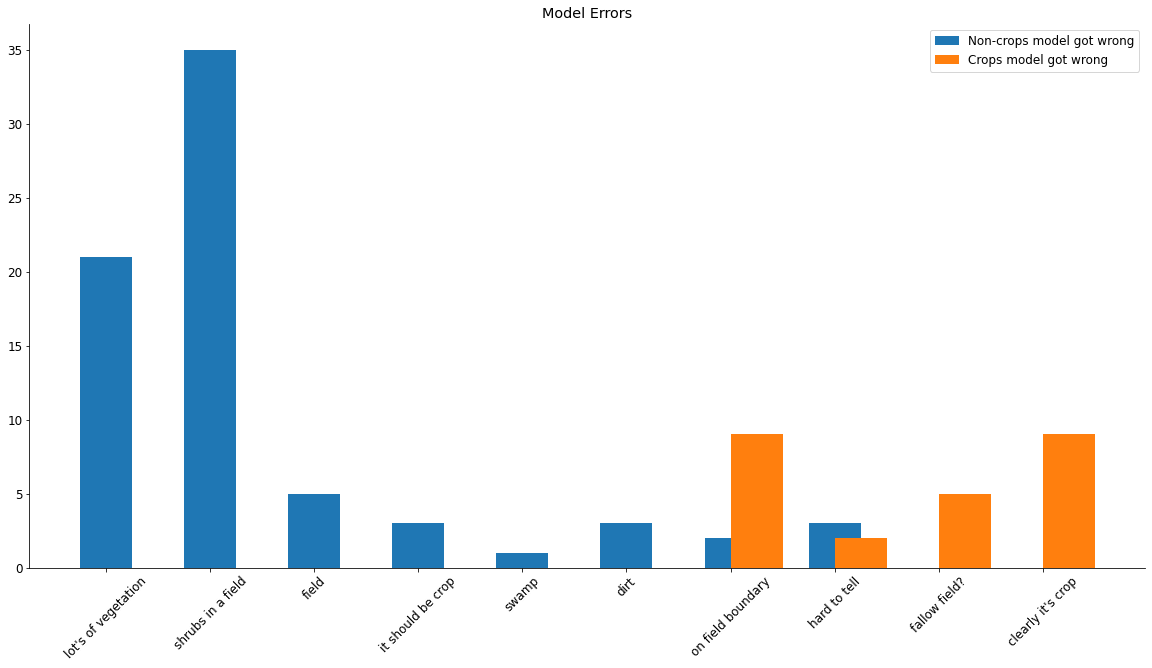

In [171]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.bar(
    x=list(non_crops_model_got_wrong.keys()), 
    height=list(non_crops_model_got_wrong.values()), 
    width=0.5, 
    label="Non-crops model got wrong")
ax.tick_params(axis='x', rotation=45)
ax.set_title("Model Errors")

ax.bar(
    x=list(crops_model_got_wrong.keys()), 
    height=list(crops_model_got_wrong.values()), 
    width=0.5, 
    align="edge", 
    label="Crops model got wrong")
ax.legend();
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

**Conclusion**: Lot's of errors from shrubs on field.

Are many of these in wildlife preserves and parks?

# 6. Are many errors inside parks?

In [303]:
raw_dir = get_dvc_dir("raw")
dfs = []
for filename in [
    "WDPA_WDOECM_Aug2021_Public_UGA_shp_0.zip",
    "WDPA_WDOECM_Aug2021_Public_UGA_shp_1.zip",
    "WDPA_WDOECM_Aug2021_Public_UGA_shp_2.zip",
]:
    file_path = raw_dir / "Uganda" / filename
    dfs.append(gpd.read_file(file_path))

In [304]:
parks = pd.concat(dfs)
#df = df.set_crs(4326, allow_override=True)

In [305]:
points = pd.DataFrame([{
    "crop_probability": inst.crop_probability,
    "lat": inst.label_lat,
    "lon": inst.label_lon,
    "error": inst in errors,
    "in_park": parks.geometry.contains(Point(inst.label_lon,inst.label_lat)).any(),
    "dist_to_park": parks.geometry.boundary.distance(Point(inst.label_lon,inst.label_lat)).min(),
    "mean_ndvi": inst.labelled_array.mean(axis=0)[13],
    "std_ndvi": inst.labelled_array.std(axis=0)[13]
} for inst in instances])
points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.lon, points.lat))

/opt/anaconda3/envs/landcover-mapping/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


In [306]:
points["y_true"] = y_true
points["y_local"] = y_local

In [307]:
def set_color(row):
    condition = row["in_park"] #or row["dist_to_park"] < 0.01
    
    if row["error"] and condition:
        return "darkred"
    elif row["error"]:
        return "lightcoral"
    elif condition:
        return "forestgreen"

    return "lawngreen"

points["color"] = points.apply(set_color, axis=1)

/opt/anaconda3/envs/landcover-mapping/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/envs/landcover-mapping/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


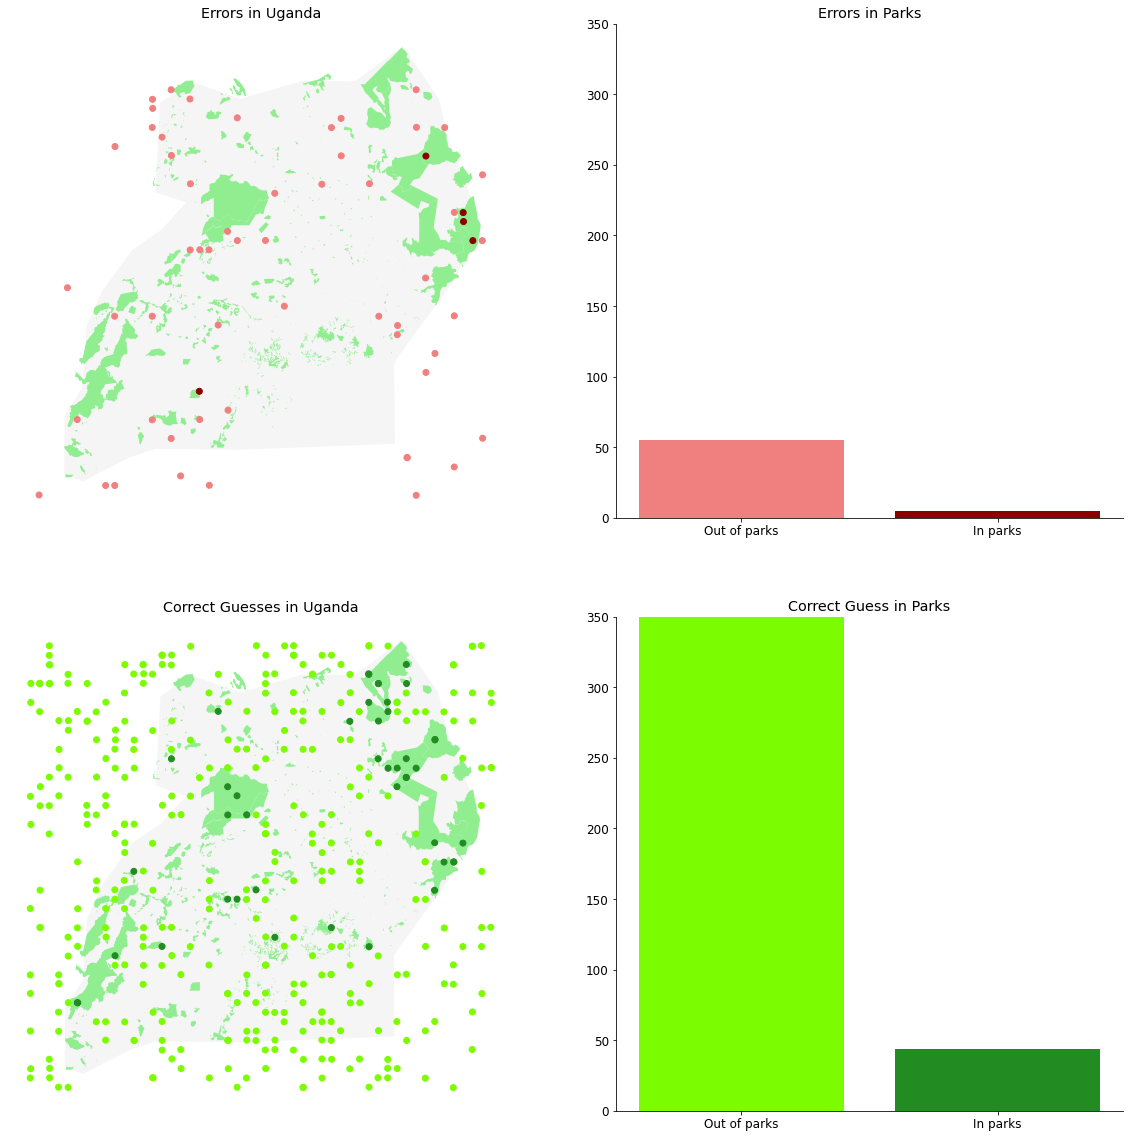

In [308]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
for i, ax in enumerate(axes):
    world[world["name"] == "Uganda"].plot(ax=ax[0], color="whitesmoke", label="Uganda")
    parks.plot(ax=ax[0], color="lightgreen", label="Parks")
    if i == 0:
        points_for_ax = points[points["error"]]
        ax[0].set_title("Errors in Uganda")
        ax[1].set_title("Errors in Parks")
    else:
        points_for_ax = points[~points["error"]]
        ax[0].set_title("Correct Guesses in Uganda")
        ax[1].set_title("Correct Guess in Parks")
    
    points_for_ax.plot(ax=ax[0], color=points_for_ax["color"])
    
    for side in ["top", "bottom", "left", "right"]:
        ax[0].spines[side].set_visible(False)
        if side in ["top", "right"]:
            ax[1].spines[side].set_visible(False)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    
    colors = points_for_ax["color"].value_counts()
    ax[1].set_xticklabels(["Out of parks", "In parks"])
    ax[1].bar(x=list(colors.keys()), height=colors, color=colors.keys())
    ax[1].set_ylim([0,350])

In [309]:
points

,crop_probability,lat,lon,error,in_park,dist_to_park,mean_ndvi,std_ndvi,geometry,y_true,y_local,color
0,0.0,3.925560,30.608389,False,False,0.460899,0.488855,0.176100,POINT (30.60839 3.92556),0,0.0,lawngreen
1,0.0,2.077666,30.117602,False,False,0.715807,0.644112,0.126515,POINT (30.11760 2.07767),0,0.0,lawngreen
2,0.0,-1.492135,31.477149,True,False,0.492044,0.374964,0.176924,POINT (31.47715 -1.49213),0,1.0,lightcoral
3,0.0,3.550545,35.170270,False,False,0.746409,0.101390,0.031722,POINT (35.17027 3.55054),0,0.0,lawngreen
4,0.0,-0.016707,32.215485,False,False,0.046726,-0.014574,0.122896,POINT (32.21549 -0.01671),0,0.0,lawngreen
...,...,...,...,...,...,...,...,...,...,...,...,...
453,0.0,3.801708,30.484255,False,False,0.531203,0.653600,0.127025,POINT (30.48426 3.80171),0,0.0,lawngreen
454,0.0,-1.368398,33.813958,False,False,1.509052,0.195262,0.081048,POINT (33.81396 -1.36840),0,0.0,lawngreen
455,0.0,-0.143357,29.499626,False,False,0.236779,0.469822,0.202560,POINT (29.49963 -0.14336),0,0.0,lawngreen
456,0.0,-0.142818,33.941146,False,False,0.385970,-0.207293,0.107390,POINT (33.94115 -0.14282),0,0.0,lawngreen


In [310]:
points["y_local_park_filter"] = points["y_local"]
points.loc[points["in_park"], "y_local_park_filter"] = 0

In [311]:
y_local_park_filter = points["y_local_park_filter"].to_list()

In [312]:
# Total predictions changed
def compute_change(y_new, reason):
    total_preds_changed = len(y_local[y_local != y_new])
    correct_changes = len(y_local[(y_local != y_new) & (y_new == y_true)])
    incorrect_changes = len(y_local[(y_local != y_new) & (y_new != y_true)])
    print(f"Total predictions changed from to non-crop because of {reason}: {total_preds_changed}")
    print(f"Changes that resulted in correct prediction: {correct_changes}")
    print(f"Changes that resulted in incorrect prediction: {incorrect_changes}")
    
    print("\nF1 Score change")
    print(f1_score(y_true, y_local))
    print(f1_score(y_true, y_new))
    
    print("\nAccuracy change")
    print(accuracy_score(y_true, y_local))
    print(accuracy_score(y_true, y_new))
    

In [313]:
compute_change(y_local_park_filter, "parks")

Total predictions changed from to non-crop because of parks: 7
Changes that resulted in correct prediction: 5
Changes that resulted in incorrect prediction: 2

F1 Score change
0.423076923076923
0.41237113402061853

Accuracy change
0.868995633187773
0.8755458515283843


In [314]:
crops_in_parks = points[(y_local != y_local_park_filter) & (y_local_park_filter != y_true)]
lat = crops_in_parks.iloc[1]["lat"]
lon = crops_in_parks.iloc[1]["lon"]
print(gmap_url(lon, lat))

http://maps.google.com/maps?z=12&t=m&q=loc:1.33768694+34.68038134


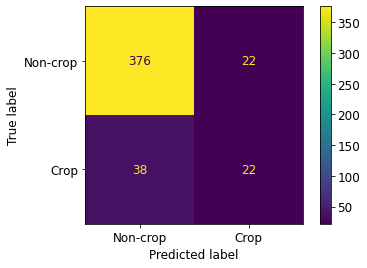

In [315]:
cm = confusion_matrix(y_true, y_local)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-crop", "Crop"])
disp.plot()

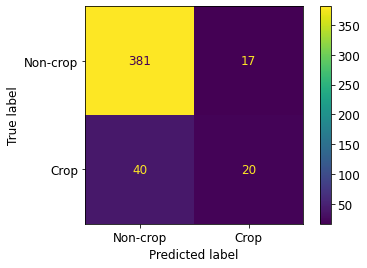

In [316]:
# Filtering by parks helped reduce wrong crop guesses
cm = confusion_matrix(y_true, y_local_park_filter)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-crop", "Crop"])
disp.plot()

# 7. Can we threshold NDVI to get better results?

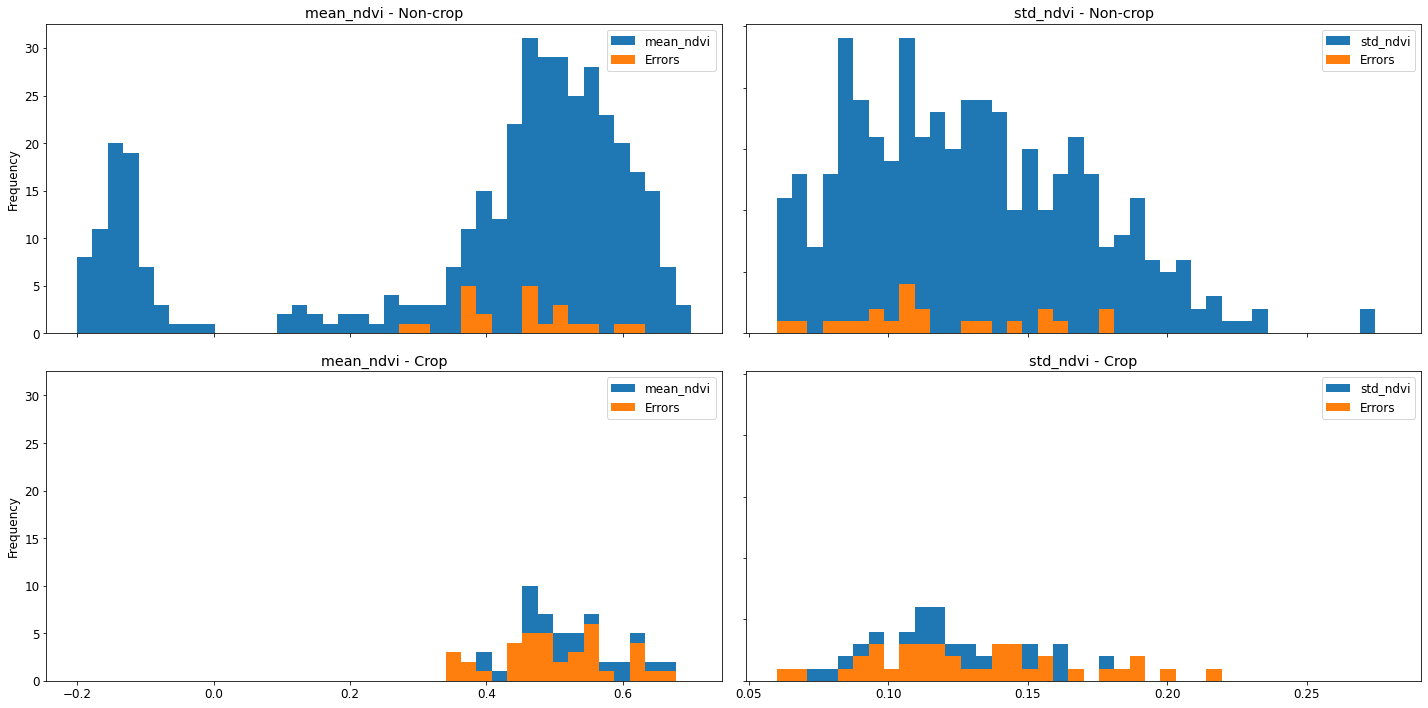

In [317]:
fig, axes = plt.subplots(2,2, figsize=(20,10), sharex="col", sharey="col")

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        col = "mean_ndvi" if j == 0 else "std_ndvi"
        if col == "mean_ndvi":
            ran = (-0.2, 0.7)
        else:
            ran = (0.06, 0.28)
        
        points[points["y_true"] == i][col].plot.hist(ax=ax, range=ran, bins=40, label=col)
        points[(points["y_true"] == i) &  (points["error"])][col].plot.hist(ax=ax, range=ran, bins=40, label="Errors")
        
        title =  f"{col} - " + ("Crop" if i == 1 else "Non-crop")
        ax.set_title(title)
        ax.legend()

fig.tight_layout()

- Generally crops have mean NDVI > 0.3, so mean NDVI < 0.3 => non-crop

In [320]:
points["y_local_ndvi_filter"] = points["y_local"]
points.loc[points["mean_ndvi"] < 0.39, "y_local_ndvi_filter"] = 0
y_local_ndvi_filter = points["y_local_ndvi_filter"].to_list()

# Total predictions changed
compute_change(y_local_ndvi_filter, "NDVI")

Total predictions changed from to non-crop because of NDVI: 8
Changes that resulted in correct prediction: 8
Changes that resulted in incorrect prediction: 0

F1 Score change
0.423076923076923
0.45833333333333326

Accuracy change
0.868995633187773
0.8864628820960698


# 8. Combining improvements from parks + NDVI 

In [321]:
points["y_local_parks_ndvi"] = points["y_local_ndvi_filter"]
points.loc[points["y_local_park_filter"] == 0, "y_local_parks_ndvi"] = 0
y_local_parks_ndvi = points["y_local_parks_ndvi"].to_list()
compute_change(y_local_parks_ndvi, "Parks + NDVI")

Total predictions changed from to non-crop because of Parks + NDVI: 13
Changes that resulted in correct prediction: 11
Changes that resulted in incorrect prediction: 2

F1 Score change
0.423076923076923
0.4395604395604395

Accuracy change
0.868995633187773
0.888646288209607


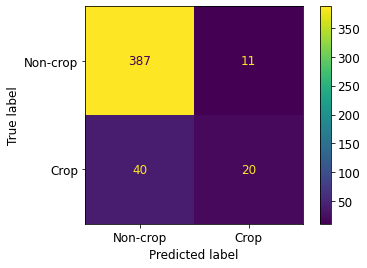

In [322]:
# Filtering by parks helped reduce wrong crop guesses
cm = confusion_matrix(y_true, y_local_parks_ndvi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-crop", "Crop"])
disp.plot()

# 9. Using different models on the Uganda validation set

In [205]:
model_dataset_metrics = {'Global': {'Rwanda': 0.6522, 'Kenya': 0.9328, 'Togo': 0.7614, 'Uganda': 0.4331}, 'Rwanda': {'Rwanda': 0.6647, 'Kenya': 0.8549, 'Togo': 0.7153, 'Uganda': 0.3438}, 'Kenya': {'Rwanda': 0.6187, 'Kenya': 0.9474, 'Togo': 0.2745, 'Uganda': 0.4359}, 'Togo': {'Rwanda': 0.4228, 'Kenya': 0.7443, 'Togo': 0.8129, 'Uganda': 0.3375}, 'Uganda': {'Rwanda': 0.6007, 'Kenya': 0.9211, 'Togo': 0.1778, 'Uganda': 0.4211}, 'Uganda_surrounding_5': {'Rwanda': 0.6689, 'Kenya': 0.9386, 'Togo': 0.1695, 'Uganda': 0.4387}}

In [206]:
df = pd.DataFrame(model_dataset_metrics)

Text(30.0, 0.5, 'Validation Set')

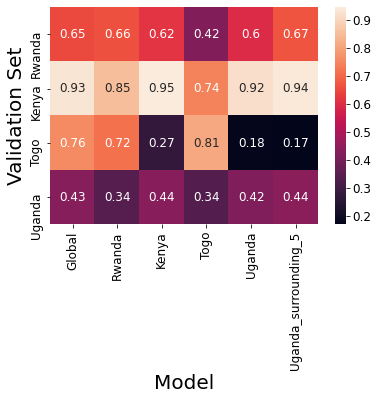

In [207]:
p = sns.heatmap(df, annot=True)
p.set_xlabel("Model", fontsize = 20)
p.set_ylabel("Validation Set", fontsize = 20)

# 10. What if make the Uganda dataset more like the others?

In [323]:
points["y_true"].value_counts()

0    398
1     60
Name: y_true, dtype: int64

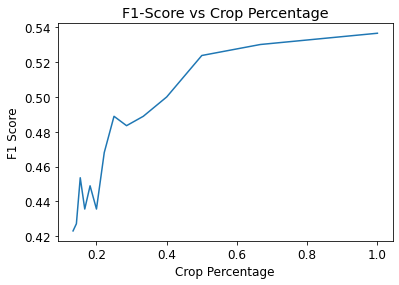

In [339]:
# How does the score change with the balance of the dataset
amount = np.arange(0,398,30)
xs = []
ys = []
for n in amount:
    points_balanced = pd.concat([
         points[points["y_true"] == 1],
        points[points["y_true"] == 0].sample(n=n)
    ])
    # If we balance our dataset to be equal crop and non crop the f1-score rises substantially
    y = f1_score(points_balanced["y_local"].to_list(), points_balanced["y_true"].to_list())
    ys.append(y)
    xs.append(60/(60+n))
    
fig, ax = plt.subplots(1,1)
ax.plot(xs, ys)
ax.set_title("F1-Score vs Crop Percentage")
ax.set_xlabel("Crop Percentage")
ax.set_ylabel("F1 Score");

The higher the crop percentage in the dataset the better we perform.

 # 11. Does Uganda just have a lot of clouds?

In [119]:
from s2cloudless import S2PixelCloudDetector

In [120]:
cloud_detector = S2PixelCloudDetector(
    threshold=0.4,
    average_over=4,
    dilation_size=2,
    all_bands=True
)

In [121]:
def get_band_values(inst):
    tif = load_tif_from_inst(inst)
    band_values = tif.sel(x=inst.instance_lon).sel(y=inst.instance_lat).values
    return band_values

def get_cloud_prob(band_values):
    #tif = load_tif_from_inst(inst)
    #band_values = tif.sel(x=inst.instance_lon).sel(y=inst.instance_lat).values
    bands_for_model = np.expand_dims(band_values, axis=(1,2))
    cloud_prob = cloud_detector.get_cloud_probability_maps(pixel_for_model).flatten()
    return cloud_prob

In [330]:
all_band_values = [get_band_values(inst) for inst in tqdm(instances)]
all_band_values_np = np.array(all_band_values)
bands_for_model = np.expand_dims(all_band_values_np, axis=2)
bands_for_model.shape

  0%|          | 0/458 [00:00<?, ?it/s]

(458, 12, 1, 13)

In [331]:
cloud_prob = cloud_detector.get_cloud_probability_maps(bands_for_model)
cloud_prob_list = list(cloud_prob[:, :, 0])

In [332]:
points["months_with_clouds_05"] = [(probabilities > 0.5).sum() for probabilities in cloud_prob_list]
points["months_with_clouds_07"] = [(probabilities > 0.7).sum() for probabilities in cloud_prob_list]
points["months_with_clouds_09"] = [(probabilities > 0.9).sum() for probabilities in cloud_prob_list]

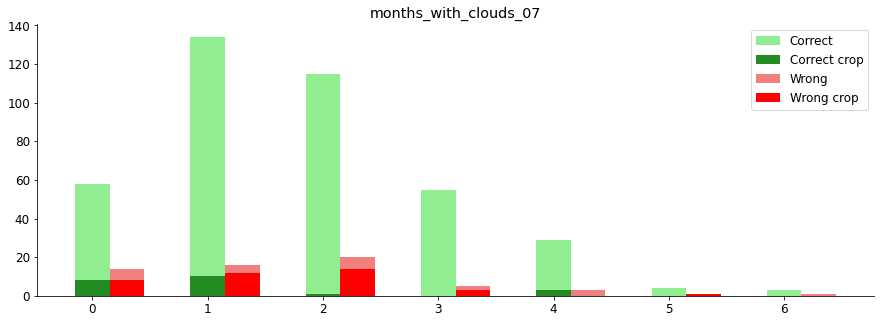

In [333]:
cloud_col = "months_with_clouds_07"
correct = points[~points["error"]][cloud_col].value_counts()
wrong = points[points["error"]][cloud_col].value_counts()

correct_crop = points[~points["error"] & points["y_true"]][cloud_col].value_counts()
wrong_crop = points[points["error"] & points["y_true"]][cloud_col].value_counts()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax.set_title(cloud_col)
ax.bar(
    x=list(correct.keys()), 
    height=list(correct), 
    width=0.3, 
    color="lightgreen",
    label="Correct")

ax.bar(
    x=list(correct_crop.keys()), 
    height=list(correct_crop), 
    width=0.3, 
    color="forestgreen",
    label="Correct crop")

ax.bar(
    x=[x+0.3 for x in list(wrong.keys())], 
    height=list(wrong), 
    width=0.3, 
    color="lightcoral",
    label="Wrong")

ax.bar(
    x=[x+0.3 for x in list(wrong_crop.keys())], 
    height=list(wrong_crop), 
    width=0.3, 
    color="red",
    label="Wrong crop")

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

**Conclusion**: There does not seem to be a trend between cloud cover.